# Look at nPRF params

transformed `.nii` to `.gii` with `surface/vol2surf_NPRFS...py`

In [1]:
import numpy as np
import nibabel as nib
from nilearn import datasets
import os.path as op
import os
import pandas as pd

bids_folder = '/mnt_03/ds-dnumrisk' 
key = 'encoding_model.denoise'
subList = [f[4:6] for f in os.listdir(op.join(bids_folder,'derivatives',key)) if f[0:4] == 'sub-' and len(f) == 6]

df_participants = pd.read_csv(op.join(bids_folder, 'add_tables','subjects_recruit_scan_scanned-final.csv'), header=0) #, index_col=0
group_list = df_participants.loc[:,['subject ID','group']].rename(mapper={'subject ID': 'subject'},axis=1).dropna().astype({'subject': int, 'group': int}).set_index('subject')
group_list = group_list.reset_index()

In [2]:
from  nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage('fsaverage')

# average r2 map

In [43]:
hemi = 'R'
surf_infl = fsaverage.infl_left if hemi =='L' else fsaverage.infl_right
n_vertices = np.shape(nib.load(surf_infl).agg_data()[0])[0]
av_r2_map = np.zeros(n_vertices,)

for sub in subList:
    source_dir = op.join(bids_folder,'derivatives',key,f'sub-{sub}', 'ses-1', 'func')
    surf =  op.join(source_dir, f'sub-{sub}_ses-1_desc-r2.optim.nilearn_space-fsaverage_hemi-{hemi}.func.gii')
    av_r2_map += nib.load(surf).agg_data()

av_r2_map = av_r2_map/len(subList)


In [44]:
# save
target_dir = op.join(bids_folder,'derivatives',key,'averages')
group = 'all'
par = 'r2'
im = nib.gifti.GiftiImage(darrays=[nib.gifti.GiftiDataArray(av_r2_map)])
target_fn =  op.join(target_dir, f'group-{group}_desc-{par}.optim.nilearn_space-fsaverage_hemi-{hemi}.func.gii')
nib.save(im, target_fn)
print(f'saving as {target_fn}')


saving as /mnt_03/ds-dnumrisk/derivatives/encoding_model.denoise/averages/group-all_desc-r2.optim.nilearn_space-fsaverage_hemi-R.func.gii


In [54]:
# groups seperate

group = 1
target_dir = op.join(bids_folder,'derivatives',key,'averages')
par = 'r2'

subList_fil = [sub for sub in subList if int(sub) in group_list[group_list['group']== group]['subject']]

for hemi in ['L', 'R']:
    surf_infl = fsaverage.infl_left if hemi =='L' else fsaverage.infl_right
    n_vertices = np.shape(nib.load(surf_infl).agg_data()[0])[0]
    av_r2_map = np.zeros(n_vertices,)
    
    for sub in subList_fil:
        source_dir = op.join(bids_folder,'derivatives',key,f'sub-{sub}', 'ses-1', 'func')
        surf =  op.join(source_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-fsaverage_hemi-{hemi}.func.gii')
        av_r2_map += nib.load(surf).agg_data()
    av_r2_map = av_r2_map/len(subList)
    im = nib.gifti.GiftiImage(darrays=[nib.gifti.GiftiDataArray(av_r2_map)])
    target_fn =  op.join(target_dir, f'group-{group}_desc-{par}.optim.nilearn_space-fsaverage_hemi-{hemi}.func.gii')
    nib.save(im, target_fn)
    print(f'saving as {target_fn}')

saving as /mnt_03/ds-dnumrisk/derivatives/encoding_model.denoise/averages/group-1_desc-r2.optim.nilearn_space-fsaverage_hemi-L.func.gii
saving as /mnt_03/ds-dnumrisk/derivatives/encoding_model.denoise/averages/group-1_desc-r2.optim.nilearn_space-fsaverage_hemi-R.func.gii


In [38]:
# visualize via pycortex (on local)

import cortex
from nilearn import image
import numpy as np
import os.path as op
import nibabel as nib

group = 'diff'
subject = 'fsaverage'

im1L= f'/Users/mrenke/data/ds-dnumrisk/derivatives/encoding_model.denoise/averages/group-{group}_desc-r2.optim.nilearn_space-fsaverage_hemi-L.func.gii'
im1L = nib.load(im1L)
im1R= f'/Users/mrenke/data/ds-dnumrisk/derivatives/encoding_model.denoise/averages/group-{group}_desc-r2.optim.nilearn_space-fsaverage_hemi-R.func.gii'
im1R = nib.load(im1R)

r2_surf = cortex.dataset.Vertex(np.concatenate([im1L.agg_data(), im1R.agg_data()], axis=0), subject=subject,cmap='viridis' ) #'viridis_r' 
ds = cortex.Dataset(r2=r2_surf)
cortex.webshow(ds) 


## Test differnces in r2 maps between groups

In [56]:
## just averages (simple but invalid)

source_dir = op.join(bids_folder,'derivatives',key,'averages')

for hemi in ['L', 'R']:
    surf =  op.join(source_dir, f'group-0_desc-{par}.optim.nilearn_space-fsaverage_hemi-{hemi}.func.gii')
    av_r2_map_g1 = nib.load(surf).agg_data()
    surf =  op.join(source_dir, f'group-1_desc-{par}.optim.nilearn_space-fsaverage_hemi-{hemi}.func.gii')
    av_r2_map_g0 = nib.load(surf).agg_data()

    av_r2_map_dif = av_r2_map_g1 - av_r2_map_g0
    im = nib.gifti.GiftiImage(darrays=[nib.gifti.GiftiDataArray(av_r2_map_dif)])
    target_fn =  op.join(source_dir, f'group-diff_desc-{par}.optim.nilearn_space-fsaverage_hemi-{hemi}.func.gii')
    nib.save(im, target_fn)
    print(f'saving as {target_fn}')


saving as /mnt_03/ds-dnumrisk/derivatives/encoding_model.denoise/averages/group-diff_desc-r2.optim.nilearn_space-fsaverage_hemi-L.func.gii
saving as /mnt_03/ds-dnumrisk/derivatives/encoding_model.denoise/averages/group-diff_desc-r2.optim.nilearn_space-fsaverage_hemi-R.func.gii


In [20]:
# difference statistciallt valid
par = 'r2'
hemi = 'R'

def load_r2surf(sub):
    source_dir = op.join(bids_folder,'derivatives',key,f'sub-{sub}', 'ses-1', 'func')
    surf =  op.join(source_dir, f'sub-{sub}_ses-1_desc-{par}.optim.nilearn_space-fsaverage_hemi-{hemi}.func.gii')
    return nib.load(surf).agg_data()

subList_fil_g0 = [sub for sub in subList if int(sub) in group_list[group_list['group']== 0]['subject']]
group0_data = [load_r2surf(sub) for sub in subList_fil_g0]
subList_fil_g1 = [sub for sub in subList if int(sub) in group_list[group_list['group']== 1]['subject']]
group1_data = [load_r2surf(sub) for sub in subList_fil_g1]

group0_data = np.array(group0_data)
group1_data = np.array(group1_data)

In [23]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

t_values, p_values = ttest_ind(group0_data, group1_data, axis=0) # Perform t-test for each vertex
corrected_p_values = multipletests(p_values, method='fdr_bh')[1] # Correct p-values for multiple comparisons using FDR

# Create a statistical map to visualize
thresh = 0.7
import matplotlib.pyplot as plt
stat_map = np.zeros_like(group1_data[0])
stat_map[corrected_p_values < thresh] = t_values[corrected_p_values < thresh]
# --> stat_map all 0 !! nothign survives

0.6020679336712897


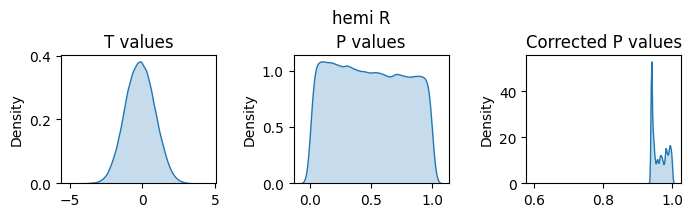

In [22]:
import seaborn as sns

fig, axs = plt.subplots(1,3, figsize=(8,2))
sns.kdeplot(t_values, fill=True,ax=axs[0])
sns.kdeplot(p_values, fill=True,ax=axs[1])
sns.kdeplot(corrected_p_values, fill=True,ax=axs[2])

for i, title in enumerate(['T values', 'P values', 'Corrected P values']):
    axs[i].set_title(title)
plt.subplots_adjust(wspace=0.5, top=0.75)
fig.suptitle(f'hemi {hemi}')

print(np.min(corrected_p_values))

## Plotting

In [8]:
group = 'all'
hemi = 'L'
fn = f'/mnt_03/ds-dnumrisk/derivatives/encoding_model.denoise/averages/group-{group}_desc-r2.optim.nilearn_space-fsaverage_hemi-{hemi}.func.gii'
surf_map = nib.load(fn).agg_data()

R


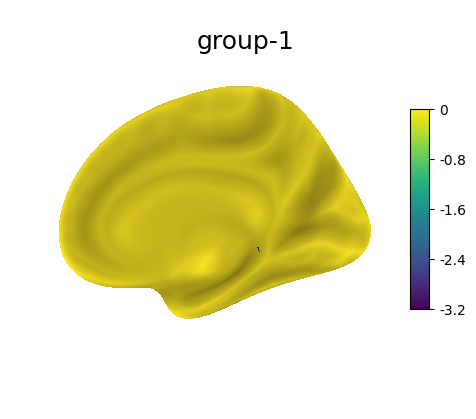

In [25]:
import nilearn.plotting as nplt
import matplotlib.pyplot as plt

surf_map = stat_map

print(hemi)

surf_mesh = fsaverage.infl_left if hemi =='L' else fsaverage.infl_right
bg_map = fsaverage.sulc_left if hemi =='L' else fsaverage.sulc_right
view = 'lateral'
nplt.plot_surf(surf_mesh= surf_mesh, surf_map= surf_map, # infl_right # pial_right
               view= view,colorbar=True,cmap='viridis',
               bg_map=bg_map, bg_on_data=True,darkness=0.5,title=f'group-{group}',
               )
#plt.title(f'group-{group}')
plt.show()

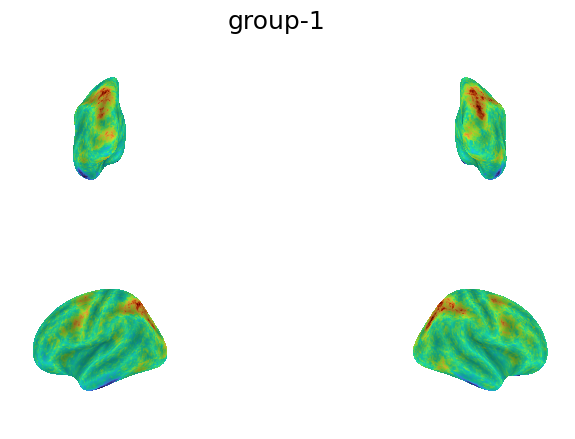

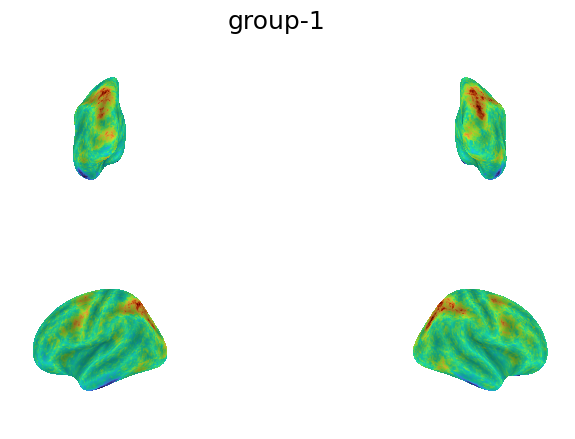

In [16]:
group = '1'
fn_l = f'/mnt_03/ds-dnumrisk/derivatives/encoding_model.denoise/averages/group-{group}_desc-r2.optim.nilearn_space-fsaverage_hemi-L.func.gii'
surf_mapL = nib.load(fn_l).agg_data()
fn_r = f'/mnt_03/ds-dnumrisk/derivatives/encoding_model.denoise/averages/group-{group}_desc-r2.optim.nilearn_space-fsaverage_hemi-R.func.gii'
surf_mapR = nib.load(fn_r).agg_data()

cmap = 'turbo' 
figure, axes = plt.subplots(nrows=2, ncols=2, figsize=(9,5),subplot_kw=dict(projection='3d'))
nplt.plot_surf(surf_mesh= fsaverage.infl_left, surf_map= surf_mapL, # infl_right # pial_right
               view= 'posterior',cmap=cmap, colorbar=False, title=f'group-{group}', axes=axes[0,0],
               bg_map=fsaverage.sulc_left, bg_on_data=True,darkness=0.5)
nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= surf_mapR, # infl_right # pial_right
               view= 'posterior',cmap=cmap, colorbar=False, axes=axes[0,1],  
               bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.5)
nplt.plot_surf(surf_mesh= fsaverage.infl_left, surf_map= surf_mapL, # infl_right # pial_right
               view= 'lateral',cmap=cmap, colorbar=False,axes=axes[1,0],
               bg_map=fsaverage.sulc_left, bg_on_data=True,darkness=0.5)
nplt.plot_surf(surf_mesh= fsaverage.infl_right, surf_map= surf_mapR, # infl_right # pial_right
               view= 'medial',cmap=cmap, colorbar=False, axes=axes[1,1],  
               bg_map=fsaverage.sulc_right, bg_on_data=True,darkness=0.5)


In [ ]:
# individual 

sub = '01'
hemi = 'L'
target_dir = op.join(bids_folder,'derivatives',key,f'sub-{sub}', 'ses-1', 'func')
surf =  op.join(target_dir, f'sub-{sub}_ses-1_desc-r2.optim.nilearn_space-fsaverage_hemi-{hemi}.func.gii')

import nilearn.plotting as nplt
from  nilearn.datasets import fetch_surf_fsaverage
fsaverage = fetch_surf_fsaverage('fsaverage')

surf_mesh = fsaverage.infl_left
surf_map = surf
bg_map = fsaverage.sulc_left
view = 'posterior'
nplt.plot_surf(surf_mesh= surf_mesh, surf_map= surf_map, # infl_right # pial_right
               view= view,colorbar=True,cmap='viridis',
               bg_map=bg_map, bg_on_data=True,darkness=0.5,
               )
plt.show()

from nilearn import datasets, surface
import matplotlib.pyplot as plt

curv = surface.load_surf_data(fsaverage.curv_left)
curv_sign = np.sign(curv)

nplt.plot_surf_stat_map(surf_mesh= fsaverage.infl_left,stat_map= surf_map, 
    view='posterior',
    hemi='right',
    #title=f'{model_n}, {con}', colorbar=True,
    threshold=0.01, bg_map=curv_sign) # bg_map: Background image to be plotted on the mesh underneath the stat_map in greyscale
plt.show()